A notebook for guiding image capture and reflectance and stereo calibration with the OROCHI laboratory simulator.

# Overview

The steps are as follows. Note that dark image capture is reserved for the end, to minimise physical interactions with the cameras.

1. Reflectace Calibration Target Imaging
    - Prompt: Lens Cap removal, put calibration target in place
    - Cycle over cameras. For each camera:
        - Test the connection
        - load/configure the camera
        - get optimal exposure and check ROI
        - capture repeat images of the calibration target
        - save the images
        - save the exposures used
2. Geometric Calibration Target Imaging
    - Prompt: Lens Cap removal, put geometric calibration target in place
    - Cycle over cameras. For each camera:
        - Test the connection
        - load/configure the camera
        - get optimal exposure and check ROI
        - capture repeat images of the geometric calibration target
        - save the images
        - save the exposures used
3. Sample Imaging
    - as above, but with the sample replacing the calibration target
4. Dark Imaging
    - Prompt: Lens cap on / lights out
    - Cycle over cameras. For each camera:
        - check connection
            - Calibration darks:
                - load calibration exposure for given camera
                - set exposure
                - capture repeat frames
                - save frames
            - Sample darks:
                - as aove but load sample exposures instead
5. Processing to Reflectance

# Functions

Here we iniatilise the functions, used in the previous notebooks, for the camera control.

In [39]:
import tisgrabber as tis
from pathlib import Path
import ctypes
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd

# get the location of the tisgrabber_x64.dll file
tis_dir = Path(tis.__file__).resolve().parents[0]
tis_dll = str(Path(tis_dir, 'tisgrabber_x64.dll'))

# Load/Initiate the tisgrabber library
ic = ctypes.cdll.LoadLibrary(tis_dll)
tis.declareFunctions(ic)
ic.IC_InitLibrary(0)

1

Define a function for setting the camera properties.

In [2]:
def set_property(property: str, element: str, value, interface: str, hGrabber):
    
    if interface == 'Range':
        set_property_func = ic.IC_SetPropertyValue
        value = ctypes.c_int(value)
    elif interface == 'AbsoluteValue':
        set_property_func = ic.IC_SetPropertyAbsoluteValue
        value = ctypes.c_float(value)
    elif interface == 'AbsoluteValueRange':
        set_property_func = ic.IC_SetPropertyAbsoluteValueRange
        value = ctypes.c_float(value)
    elif interface == 'Switch':
        set_property_func = ic.IC_SetPropertySwitch
        value = ctypes.c_int(value)
    elif interface == 'MapStrings':
        set_property_func = ic.IC_SetPropertyMapStrings
        value = ctypes.c_char(value)
    elif interface == 'Button':
        set_property_func = ic.IC_SetPropertyOnePush
        value = ctypes.c_int(value)

    ret = set_property_func(
            hGrabber, 
            property.encode("utf-8"),
            element.encode("utf-8"), 
            value)
    if ret == 1:
        print(f'{property} {element} set to {value.value}')
    elif ret == -2:
        raise ValueError('No video capture device opened')
    elif ret == -4:
        raise ValueError(f'{property} is not available')
    elif ret == -5:
        raise ValueError(f'{property} item {element} is not available')
    elif ret == -6:
        raise ValueError(f'{property} {element} has no interface')

Define a function to set all camera properties:

In [3]:
def set_defaults(grabber, exposure=1.0/100, auto_exposure=1, black_level=26):
    black_level = black_level*2**4
    set_property('Brightness', 'Value', black_level, 'Range', grabber) # brightness is Black Level in DN for the 12-bit range of the detector. Default is to 10% of detector range, for linearity
    set_property('Contrast', 'Value', 0, 'Range', grabber)
    set_property('Sharpness', 'Value', 0, 'Range', grabber)    
    set_property('Gamma', 'Value', 100, 'Range', grabber)
    set_property('Gain', 'Value', 0.0, 'AbsoluteValue', grabber)
    set_property('Gain', 'Auto', 0, 'Switch', grabber)
    set_property('Exposure', 'Value', exposure, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', auto_exposure, 'Switch', grabber)
    set_property('Exposure', 'Auto Reference', 80, 'Range', grabber)
    set_property('Exposure', 'Auto Max Value', 2.0, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto Max Auto', 0, 'Switch', grabber)
    set_property('Trigger', 'Enable', 0, 'Switch', grabber)
    set_property('Denoise', 'Value', 0, 'Range', grabber)
    set_property('Flip Horizontal', 'Enable', 0, 'Switch', grabber)
    set_property('Flip Vertical', 'Enable', 0, 'Switch', grabber)
    set_property('Highlight Reduction', 'Enable', 0, 'Switch', grabber)
    set_property('Tone Mapping', 'Enable', 0, 'Switch', grabber)
    set_property('Strobe', 'Enable', 0, 'Switch', grabber)
    set_property('Auto Functions ROI', 'Enabled', 0, 'Switch', grabber)

Define a function for getting image settings:

In [4]:
def get_image_info(grabber):
    width = ctypes.c_long()
    height = ctypes.c_long()
    bits = ctypes.c_long()
    col_fmt = ctypes.c_int()

    ic.IC_GetImageDescription(grabber, width, height,
                            bits, col_fmt)


    bpp = int(bits.value / 8.0)
    buffer_size = width.value * height.value * bits.value

    return width.value, height.value, buffer_size, bpp

Define a function for capturing an image and returning it as an numpy array:

In [5]:
def image_capture(grabber, camera=None, roi=False):

    ic.IC_StartLive(grabber,1)
    ic.IC_SnapImage(grabber, 2000) == tis.IC_SUCCESS
    ic.IC_StopLive(grabber,1)

    width, height, buffer_size, bpp = get_image_info(grabber)

    # Get the image data
    imagePtr = ic.IC_GetImagePtr(grabber)

    imagedata = ctypes.cast(imagePtr,
                            ctypes.POINTER(ctypes.c_ubyte *
                                        buffer_size))

    # Create the numpy array
    image = np.ndarray(buffer=imagedata.contents,
                    dtype=np.uint8,
                    shape=(height,
                            width,
                            bpp))

    if roi:
        x = camera['roi']['x']
        y = camera['roi']['y']
        w = camera['roi']['w']
        h = camera['roi']['h']
        image = image[y:y+h,x:x+w,0]
    else:
        image = image[:,:,0]
    return image

Define a function to look at the image:

In [6]:
def show_image(img_arr, title):
    plt.imshow(img_arr, origin='lower')
    plt.title(title)
    plt.colorbar()

Define and call a function for getting the last used exposure:

In [7]:
def get_property(property: str, element: str, interface: str, hGrabber):

    container = ctypes.c_float()
    ret = ic.IC_GetPropertyAbsoluteValue(
            hGrabber, 
            tis.T(property), 
            tis.T("Value"), container)
    if ret == 1:
        # print(f'{property} current {element}: {container.value}')
        return container.value
    elif ret == -2:
        raise ValueError('No video capture device opened')
    elif ret == -4:
        raise ValueError('Property item is not available')
    elif ret == -5:
        raise ValueError('Property item element is not available')
    elif ret == -6:
        raise ValueError('Requested element has no interface')
    return container.value

Implement exposure seeking function:

In [8]:
def find_exposure(grabber, camera, init_t_exp=1.0/100, target=150, n_hot=10, tol=1, limit=5, roi=True):
    # initialise while loop
    searching = True
    trial_n = 0

    # ensure exposure setting is manual
    print('Initiating search:')
    set_property('Exposure', 'Value', init_t_exp, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)

    while searching == True:
        print(f'Trial {trial_n}:')
        img_arr = image_capture(grabber, camera, roi) # capture the image
        k = 1 - n_hot/img_arr.size
        k_quantile = np.round(np.quantile(img_arr, k)) # evaluate the quantile
        success = target - k_quantile <= tol # check against target
        
        if success == True:
            print(f'Success after {trial_n} trials')
            t_exp = get_property('Exposure', 'Value', 'AbsoluteValue', grabber)
            searching = False # update searcing or continue
            return t_exp

        t_exp_scale = target / k_quantile # get the scaling factor
        last_t_exp = get_property('Exposure', 'Value', 'AbsoluteValue', grabber) # get the current exposure
        new_t_exp = t_exp_scale * last_t_exp# scale the exposure
        set_property('Exposure', 'Value', new_t_exp, 'AbsoluteValue', grabber) # update the camera settings
        trial_n+=1 # increment the counter
        failure = trial_n > limit

        if failure == True:
            print(f'Failure to satisfy tolerance. Exiting routine.')
            t_exp = get_property('Exposure', 'Value', 'AbsoluteValue', grabber)
            searching = False
            return t_exp
    
    return None

Save an image:

In [9]:
def save_tiff(name, target, img_type, img_arr, grabber, camera):

    exposure = get_property('Exposure', 'Value', 'AbsoluteValue', grabber)
    metadata={
        'camera': camera['number'],
        'serial': camera['serial'],
        'cwl': camera['cwl'],
        'fwhm': camera['fwhm'],
        'f-number': camera['fnumber'],
        'f-length': camera['flength'],
        'exposure': exposure,
        'image-type': img_type, # image or dark frame or averaged stack
        'target': target
    }
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = cwl_str+'_'+name+'_'+img_type
    img_file =str(Path(target_dir, filename).with_suffix('.tif'))
    # write camera properties to TIF using ImageJ metadata
    tiff.imwrite(img_file, img_arr, imagej=True, metadata=metadata)
    print(f'Image {name} written to {img_file}')

Configure device lost callback code:

In [10]:
class CallbackUserdata(ctypes.Structure):
    """ Example for user data passed to the callback function. 
    """
    def __init__(self, ):
        self.unsused = ""
        self.devicename = ""
        self.connected = False


def frameReadyCallback(hGrabber, pBuffer, framenumber, pData):
    # Maybe do something here.
    return


def deviceLostCallback(hGrabber, userdata):
    """ This a device lost callback function. Called, if the camera disconnects. 
    This function runs in the Grabber thread, not in the main thread.
    :param: hGrabber: This is the real pointer to the grabber object. Do not use.
    :param: pData : Pointer to additional user data structure
    """
    userdata.connected = False
    print("Device {} lost".format(userdata.devicename))

frameReadyCallbackfunc = ic.FRAMEREADYCALLBACK(frameReadyCallback)
userdata = CallbackUserdata()
devicelostcallbackfunc = ic.DEVICELOSTCALLBACK(deviceLostCallback)

# Looping Over Multiple Channels

We loop over multiple cameras by defining a list of cameras, and defining  dictionary, indexed by this list, giving the camera descriptions required to load and control each camera.

Here, we just use the cameras labelled '3' and '6' that I have in my office, but this will be replaced with the complete set on the OROCHI simulator.

In [11]:
# Store a list of cameras and properties here.
# Note, values are placeholders only, not representative of actual camera.
cameras = {
       "DMK 33GX249 10910294": 
              {'number': 3,
              'serial': 10910294,
              'fnumber': 8.0,
              'flength': 12.5,
              'cwl': 550.0,
              'fwhm': 25.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 300,
                     'y': 450,
                     'w': 316,
                     'h': 256}
              },
       "DMK 33GX249 10910265":
              {'number': 6,
              'serial': 10910265,
              'fnumber': 5.8,
              'flength': 12.5,
              'cwl': 550.0,
              'fwhm': 25.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 600,
                     'y': 850,
                     'w': 316,
                     'h': 256}
              }
       }

Get a list of the cameras available, notify of missing cameras, and connect to the available cameras.

In [12]:
def connect_cameras(cameras):
    connected_cameras = []
    devicecount = ic.IC_GetDeviceCount()

    for i in range(0, devicecount):
        uniquename = tis.D(ic.IC_GetUniqueNamefromList(i))
        connected_cameras.append(uniquename)
    missing_cameras = set(list(cameras.keys())) - set(connected_cameras)
    if len(missing_cameras) > 0:
        print(f'Warning - cameras not connected: {missing_cameras}')
    grabbers = {}
    for camera in connected_cameras:
        cam_name = camera
        cam_num = cameras[camera]['number']
        grabber = ic.IC_CreateGrabber()
        grabbers[camera] = grabber
        ic.IC_OpenDevByUniqueName(grabber, tis.T(cam_name))

        userdata.devicename = f'{cam_num} ({cam_name})'
        userdata.connected = True

        ic.IC_SetCallbacks(grabber,
                        frameReadyCallbackfunc, None,
                        devicelostcallbackfunc, userdata)

        # check the device is connected
        if ic.IC_IsDevValid(grabber):
            print(f'Device {cam_num} ({cam_name}) succesfully connected.')
        else:
            err_string = f'Camera {cam_num} ({cam_name}) did not connect - check connection and try again'
            ic.IC_MsgBox( tis.T(err_string),tis.T("Connection Error"))
    print(f'{len(grabbers)} cameras connected.')
    return grabbers

We now have a list of camera grabbers, and will recieve messages if any of these connections are lost.

In [13]:
grabbers = connect_cameras(cameras)
bad_count = 0
while len(grabbers) == 0:
    err_string = f'No cameras connected - check connection and try again'
    ic.IC_MsgBox( tis.T(err_string),tis.T("Connection Error"))
    grabbers = connect_cameras(cameras)
    bad_count +=1
    if bad_count >= 5:
        raise ConnectionError('No cameras connect. Abort script and try again.')


Warning - cameras not connected: {'DMK 33GX249 10910265', 'DMK 33GX249 10910294'}
0 cameras connected.
Warning - cameras not connected: {'DMK 33GX249 10910294'}
Device 6 (DMK 33GX249 10910265) succesfully connected.
1 cameras connected.


# Camera Configuration

In [14]:
grabbers.values()

dict_values([<tisgrabber.LP_HGRABBER object at 0x0000021223E6F9D0>])

In [15]:
for grabber in grabbers:
    cam_num = cameras[grabber]['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_defaults(grabbers[grabber])
    print('-----------------------------------')

-----------------------------------
Device 6
-----------------------------------
Brightness Value set to 416
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 0.0
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 2.0
Exposure Auto Max Auto set to 0
Trigger Enable set to 0
Denoise Value set to 0
Flip Horizontal Enable set to 0
Flip Vertical Enable set to 0
Highlight Reduction Enable set to 0
Tone Mapping Enable set to 0
Strobe Enable set to 0
Auto Functions ROI Enabled set to 0
-----------------------------------


# Calibration Target Imaging

- Prompt: Lens Cap removal, put calibration target in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the calibration target
    - save the images
    - save the exposures used

Check:
1. The calibration target is in place
2. Lens cap is removed

In [16]:
ic.IC_MsgBox(tis.T('Check Calibration Target is in place'), tis.T('Imaging Calibration Target'))
ic.IC_MsgBox(tis.T('Check Lens Caps are removed'), tis.T('Imaging Calibration Target'))

1

In [17]:
calibration_exposures = {}
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    calibration_t_exp = find_exposure(grabber, camera)
    calibration_exposures[cam_name] = calibration_t_exp
    print('-----------------------------------')

-----------------------------------
Device 6
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Exposure Auto set to 0
Trial 0:
Exposure Value set to 0.03946973383426666
Trial 1:
Exposure Value set to 0.07893799990415573
Trial 2:
Exposure Value set to 0.09548830986022949
Trial 3:
Exposure Value set to 0.09946666657924652
Trial 4:
Success after 4 trials
-----------------------------------


Check the images:

-----------------------------------
Device 6
-----------------------------------
Exposure Value set to 0.0994660034775734
Exposure Auto set to 0
Peak Value: 192 DN
-----------------------------------


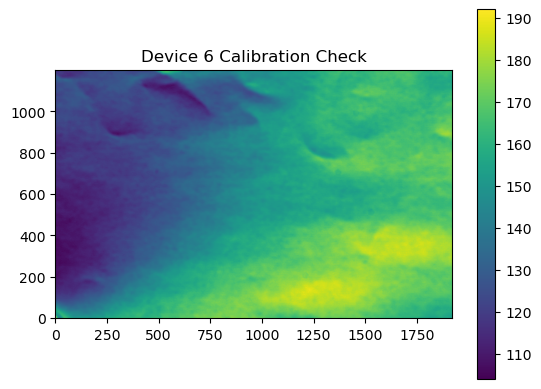

In [18]:
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', calibration_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    img_arr = image_capture(grabber, camera, roi=False)
    title = f'Device {cam_num} Calibration Check'
    show_image(img_arr,title)
    peak_dn = img_arr.max()
    print(f'Peak Value: {peak_dn} DN')
    print('-----------------------------------')

In [19]:
ic.IC_MsgBox(tis.T('Calibration Target ROIs and Exposures Ok?'), tis.T('Imaging Calibration Target'))

1

Capture the repeat images:

In [20]:
n = 10
target = 'calibrationtest'
img_type = 'img'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

-----------------------------------
Device 6
-----------------------------------
Image 0 written to calibrationtest\6_550\550_0_img.tif
Image 1 written to calibrationtest\6_550\550_1_img.tif
Image 2 written to calibrationtest\6_550\550_2_img.tif
Image 3 written to calibrationtest\6_550\550_3_img.tif
Image 4 written to calibrationtest\6_550\550_4_img.tif
Image 5 written to calibrationtest\6_550\550_5_img.tif
Image 6 written to calibrationtest\6_550\550_6_img.tif
Image 7 written to calibrationtest\6_550\550_7_img.tif
Image 8 written to calibrationtest\6_550\550_8_img.tif
Image 9 written to calibrationtest\6_550\550_9_img.tif


Write the exposure to file for quick read access:

In [21]:
for cam_name in grabbers:
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(target_dir, 'exposure_seconds.txt')
    with open(filename, 'w') as f:
            t_exp = str(calibration_exposures[cam_name])
            f.write(t_exp)

# Geometric Calibration Target Imaging

- Prompt: Lens Cap removal, put geometric calibration target in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the geometric calibration target
    - save the images
    - save the exposures used

Check:
1. The geometric calibration target is in place
2. Lens cap is removed

In [22]:
ic.IC_MsgBox(tis.T('Check Geometric Calibration Target is in place'), tis.T('Imaging Geometric Calibration Target'))
ic.IC_MsgBox(tis.T('Check Lens Caps are removed'), tis.T('Imaging Geometric Calibration Target'))

1

In [23]:
geometric_exposures = {}
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    geometric_t_exp = find_exposure(grabber, camera)
    geometric_exposures[cam_name] = geometric_t_exp
    print('-----------------------------------')

-----------------------------------
Device 6
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Exposure Auto set to 0
Trial 0:
Exposure Value set to 0.032605431973934174
Trial 1:
Exposure Value set to 0.05374450609087944
Trial 2:
Exposure Value set to 0.06107272580265999
Trial 3:
Exposure Value set to 0.06274520605802536
Trial 4:
Success after 4 trials
-----------------------------------


Check the images:

-----------------------------------
Device 6
-----------------------------------
Exposure Value set to 0.06274499744176865
Exposure Auto set to 0
Peak Value: 162 DN
-----------------------------------


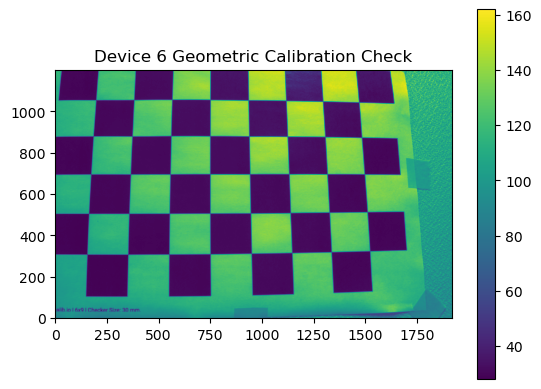

In [24]:
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', geometric_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    img_arr = image_capture(grabber, camera, roi=False)
    title = f'Device {cam_num} Geometric Calibration Check'
    show_image(img_arr,title)
    peak_dn = img_arr.max()
    print(f'Peak Value: {peak_dn} DN')
    print('-----------------------------------')

In [25]:
ic.IC_MsgBox(tis.T('Geometric Calibration Target ROIs and Exposures Ok?'), tis.T('Imaging Calibration Target'))

1

Capture the repeat images:

In [26]:
n = 10
target = 'geometrictest'
img_type = 'img'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

-----------------------------------
Device 6
-----------------------------------
Image 0 written to geometrictest\6_550\550_0_img.tif
Image 1 written to geometrictest\6_550\550_1_img.tif
Image 2 written to geometrictest\6_550\550_2_img.tif
Image 3 written to geometrictest\6_550\550_3_img.tif
Image 4 written to geometrictest\6_550\550_4_img.tif
Image 5 written to geometrictest\6_550\550_5_img.tif
Image 6 written to geometrictest\6_550\550_6_img.tif
Image 7 written to geometrictest\6_550\550_7_img.tif
Image 8 written to geometrictest\6_550\550_8_img.tif
Image 9 written to geometrictest\6_550\550_9_img.tif


Write the exposure to file for quick read access:

In [27]:
for cam_name in grabbers:
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(target_dir, 'exposure_seconds.txt')
    with open(filename, 'w') as f:
            t_exp = str(geometric_exposures[cam_name])
            f.write(t_exp)

# Sample Imaging

- Prompt: Lens Cap removal, put sample in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the sample
    - save the images
    - save the exposures used

Check:
1. The sample is in place
2. Lens cap is removed

In [28]:
ic.IC_MsgBox(tis.T('Check Sample is in place'), tis.T('Imaging Sample'))
ic.IC_MsgBox(tis.T('Check Lens Caps are removed'), tis.T('Imaging Sample'))

1

In [29]:
sample_exposures = {}
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    sample_t_exp = find_exposure(grabber, camera)
    sample_exposures[cam_name] = sample_t_exp
    print('-----------------------------------')

-----------------------------------
Device 6
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Exposure Auto set to 0
Trial 0:
Exposure Value set to 0.03332999721169472
Trial 1:
Exposure Value set to 0.05554833263158798
Trial 2:
Exposure Value set to 0.06312272697687149
Trial 3:
Exposure Value set to 0.06441020220518112
Trial 4:
Success after 4 trials
-----------------------------------


Check the images:

-----------------------------------
Device 6
-----------------------------------
Exposure Value set to 0.064410001039505
Exposure Auto set to 0
Peak Value: 166 DN
-----------------------------------


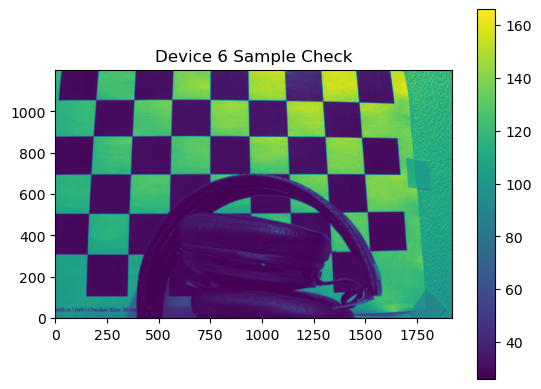

In [30]:
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', sample_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    img_arr = image_capture(grabber, camera, roi=False)
    title = f'Device {cam_num} Sample Check'
    show_image(img_arr,title)
    peak_dn = img_arr.max()
    print(f'Peak Value: {peak_dn} DN')
    print('-----------------------------------')

In [31]:
ic.IC_MsgBox(tis.T('Sample ROIs and Exposures Ok?'), tis.T('Imaging Sample'))

1

Capture the repeat images:

In [32]:
n = 10
target = 'sampletest'
img_type = 'img'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

-----------------------------------
Device 6
-----------------------------------
Image 0 written to sampletest\6_550\550_0_img.tif
Image 1 written to sampletest\6_550\550_1_img.tif
Image 2 written to sampletest\6_550\550_2_img.tif
Image 3 written to sampletest\6_550\550_3_img.tif
Image 4 written to sampletest\6_550\550_4_img.tif
Image 5 written to sampletest\6_550\550_5_img.tif
Image 6 written to sampletest\6_550\550_6_img.tif
Image 7 written to sampletest\6_550\550_7_img.tif
Image 8 written to sampletest\6_550\550_8_img.tif
Image 9 written to sampletest\6_550\550_9_img.tif


Write the exposure to file for quick read access:

In [33]:
for cam_name in grabbers:
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(target_dir, 'exposure_seconds.txt')
    with open(filename, 'w') as f:
            t_exp = str(sample_exposures[cam_name])
            f.write(t_exp)

# Dark Frame Imaging

Now we use the recorded exposures to capture dark frames.

Check:
1. Lens cap is in place

In [34]:
ic.IC_MsgBox(tis.T('Check Lens Cap is in place'), tis.T('Dark Imaging'))

1

Calibration dark images:

In [35]:
n = 10
target = 'calibrationtest'
img_type = 'drk'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', calibration_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

-----------------------------------
Device 6
-----------------------------------
Exposure Value set to 0.0994660034775734
Exposure Auto set to 0
Image 0 written to calibrationtest\6_550\550_0_drk.tif
Image 1 written to calibrationtest\6_550\550_1_drk.tif
Image 2 written to calibrationtest\6_550\550_2_drk.tif
Image 3 written to calibrationtest\6_550\550_3_drk.tif
Image 4 written to calibrationtest\6_550\550_4_drk.tif
Image 5 written to calibrationtest\6_550\550_5_drk.tif
Image 6 written to calibrationtest\6_550\550_6_drk.tif
Image 7 written to calibrationtest\6_550\550_7_drk.tif
Image 8 written to calibrationtest\6_550\550_8_drk.tif
Image 9 written to calibrationtest\6_550\550_9_drk.tif


In [36]:
n = 10
target = 'geometrictest'
img_type = 'drk'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', geometric_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

-----------------------------------
Device 6
-----------------------------------
Exposure Value set to 0.06274499744176865
Exposure Auto set to 0
Image 0 written to geometrictest\6_550\550_0_drk.tif
Image 1 written to geometrictest\6_550\550_1_drk.tif
Image 2 written to geometrictest\6_550\550_2_drk.tif
Image 3 written to geometrictest\6_550\550_3_drk.tif
Image 4 written to geometrictest\6_550\550_4_drk.tif
Image 5 written to geometrictest\6_550\550_5_drk.tif
Image 6 written to geometrictest\6_550\550_6_drk.tif
Image 7 written to geometrictest\6_550\550_7_drk.tif
Image 8 written to geometrictest\6_550\550_8_drk.tif
Image 9 written to geometrictest\6_550\550_9_drk.tif


Sample Dark Images:

In [37]:
n = 10
target = 'sampletest'
img_type = 'drk'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', sample_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

-----------------------------------
Device 6
-----------------------------------
Exposure Value set to 0.064410001039505
Exposure Auto set to 0
Image 0 written to sampletest\6_550\550_0_drk.tif
Image 1 written to sampletest\6_550\550_1_drk.tif
Image 2 written to sampletest\6_550\550_2_drk.tif
Image 3 written to sampletest\6_550\550_3_drk.tif
Image 4 written to sampletest\6_550\550_4_drk.tif
Image 5 written to sampletest\6_550\550_5_drk.tif
Image 6 written to sampletest\6_550\550_6_drk.tif
Image 7 written to sampletest\6_550\550_7_drk.tif
Image 8 written to sampletest\6_550\550_8_drk.tif
Image 9 written to sampletest\6_550\550_9_drk.tif


This completes the capture of images and dark frames for all cameras.

In [38]:
ic.IC_MsgBox(tis.T('Sequence Complete. Disconnecting Cameras'), tis.T('Sequence Complete'))

for cam_name in grabbers:
    grabber = grabbers[cam_name]
    ic.IC_ReleaseGrabber(grabber)

Next, we will access these images for reflectance processing.